# Electric Vehicle

## Úvod

Táto práca je venovaná predmetu Objavovanie znalostí ako projekt z deskriptívnej štatistiky. V našom projekte sme sa rozhodli pracovať s dátami o elektrických autách. Rozhodli sme sa tak preto, že otázka elektrických áut je čoraz viac aktuálna. Stále sa vo svete rieši cena a dojazd elektrických aut. Pracujeme s rôznymi atribútmi a zisťujeme, aké atribúty na sebe závisia, od čoho závisí cena elektrického auta a podobne.

Cieľom projektu bolo potvrdiť, alebo vyvrátiť hypotézy, ktoré sme si stanovili. Po analýze a úprave datasetu sme vypracovali predikčné modely a na základe nich sme vyhodnotili závery pre jednotlivé hypotézy.

Projekt je rozdelený do dvoch častí: praktická časť a teoretická časť. Tento dokument predstavuje praktickú časť.

Dataset: https://www.kaggle.com/datasets/geoffnel/evs-one-electric-vehicle-dataset (ElectricCarData_Clean.csv)

## Analýza dát

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import glob
import math 
import scipy as sc
import disarray

from pandas import read_csv
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, roc_auc_score, roc_curve, accuracy_score, mean_squared_error, silhouette_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from collections import Counter
from yellowbrick.cluster import KElbowVisualizer

Načítanie datasetu

In [2]:
data = pd.read_csv("ElectricCarData_Clean.csv")

### Funkcie

Úprava stĺpcov a nahradenie invalidnej hodnoty

In [3]:
def EditColumns(data):
    data = data.drop(['PlugType'], axis = 1)

    data['FastCharge_KmH'] = data['FastCharge_KmH'].astype(str).str.replace('-','0')
    data['FastCharge_KmH'] = data['FastCharge_KmH'].astype(float)

    data.columns = data.columns.str.replace('AccelSec', 'Acceleration 0-100 (s)')
    data.columns = data.columns.str.replace('TopSpeed_KmH', 'TopSpeed (km/h)')
    data.columns = data.columns.str.replace('Range_Km', 'Range (km)')
    data.columns = data.columns.str.replace('Efficiency_WhKm', 'Efficiency (Wh/km)')
    data.columns = data.columns.str.replace('FastCharge_KmH', 'FastCharge (km/h)')
    return data

Identifikácia outlierov

In [4]:
def identify_outliers(data):
    lower = data.quantile(0.25) - 1.5 * stats.iqr(data)
    upper = data.quantile(0.75) + 1.5 * stats.iqr(data)
    
    return data[(data > upper) | (data < lower)]

Pretypovanie kategorických hodnôt do spojitých

In [5]:
def ReplaceStringValues(data):
    data['PowerTrain'] = data['PowerTrain'].astype(str).str.replace('AWD','3')
    data['PowerTrain'] = data['PowerTrain'].astype(str).str.replace('RWD','2')
    data['PowerTrain'] = data['PowerTrain'].astype(str).str.replace('FWD','1')
    data['PowerTrain'] = data['PowerTrain'].astype(int)

    data['RapidCharge'] = data['RapidCharge'].astype(str).str.replace('Yes','1')
    data['RapidCharge'] = data['RapidCharge'].astype(str).str.replace('No','0')
    data['RapidCharge'] = data['RapidCharge'].astype(int)

    data['BodyStyle'] = data['BodyStyle'].astype(str).str.replace('Hatchback','1')
    data['BodyStyle'] = data['BodyStyle'].astype(str).str.replace('Liftback','2')
    data['BodyStyle'] = data['BodyStyle'].astype(str).str.replace('Sedan','3')
    data['BodyStyle'] = data['BodyStyle'].astype(str).str.replace('Station','4')
    data['BodyStyle'] = data['BodyStyle'].astype(str).str.replace('Cabrio','5')
    data['BodyStyle'] = data['BodyStyle'].astype(str).str.replace('SUV','6')
    data['BodyStyle'] = data['BodyStyle'].astype(str).str.replace('MPV','7')
    data['BodyStyle'] = data['BodyStyle'].astype(str).str.replace('SPV','8')
    data['BodyStyle'] = data['BodyStyle'].astype(str).str.replace('Pickup','9')
    data['BodyStyle'] = data['BodyStyle'].astype(int)

    data['Segment'] = data['Segment'].astype(str).str.replace('A','1')
    data['Segment'] = data['Segment'].astype(str).str.replace('B','2')
    data['Segment'] = data['Segment'].astype(str).str.replace('C','3')
    data['Segment'] = data['Segment'].astype(str).str.replace('D','4')
    data['Segment'] = data['Segment'].astype(str).str.replace('E','5')
    data['Segment'] = data['Segment'].astype(str).str.replace('F','6')
    data['Segment'] = data['Segment'].astype(str).str.replace('N','7')
    data['Segment'] = data['Segment'].astype(str).str.replace('S','8')
    data['Segment'] = data['Segment'].astype(int)

    return data

In [6]:
data = EditColumns(data)

Ukážka datasetu

In [7]:
data.head()

,Brand,Model,Acceleration 0-100 (s),TopSpeed (km/h),Range (km),Efficiency (Wh/km),FastCharge (km/h),RapidCharge,PowerTrain,BodyStyle,Segment,Seats,PriceEuro
0,Tesla,Model 3 Long Range Dual Motor,4.6,233,450,161,940.0,Yes,AWD,Sedan,D,5,55480
1,Volkswagen,ID.3 Pure,10.0,160,270,167,250.0,Yes,RWD,Hatchback,C,5,30000
2,Polestar,2,4.7,210,400,181,620.0,Yes,AWD,Liftback,D,5,56440
3,BMW,iX3,6.8,180,360,206,560.0,Yes,RWD,SUV,D,5,68040
4,Honda,e,9.5,145,170,168,190.0,Yes,RWD,Hatchback,B,4,32997


Brand - značka vozidla

Model - konkrétny model danej značky vozidla

Acceleration 0-100 (s) - akcelerácia z 0 na 100

TopSpeed (km/h) - maximálna rýchlosť

Range (km) - dojazd na jedno nabitie

Efficiency (Wh/km) - spotreba Wh elektriny na prejdenie vzdialenosti 1 km

FastCharge (km/h) - počet kilometrov za dobu 1 hodiny rýchlonabíjania

RapidCharge - udáva, či vozidlo obsahuje funkciu rýchlonabíjania

PowerTrain - typ pohonu vozidla (AWD, RWD, FWD)

PlugType - typ elektrickej zásuvky

BodyStyle - typ karosérie (sedan, cabrio, SUV, hatchback… )

Segment - trieda vozidla (B - small, D - large, E - executive, J - SUV…)

Seats - počet sedadiel

PriceEuro - cena vozidla v eurách

Základné informácie o datasete

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Brand                   103 non-null    object 
 1   Model                   103 non-null    object 
 2   Acceleration 0-100 (s)  103 non-null    float64
 3   TopSpeed (km/h)         103 non-null    int64  
 4   Range (km)              103 non-null    int64  
 5   Efficiency (Wh/km)      103 non-null    int64  
 6   FastCharge (km/h)       103 non-null    float64
 7   RapidCharge             103 non-null    object 
 8   PowerTrain              103 non-null    object 
 9   BodyStyle               103 non-null    object 
 10  Segment                 103 non-null    object 
 11  Seats                   103 non-null    int64  
 12  PriceEuro               103 non-null    int64  
dtypes: float64(2), int64(5), object(6)
memory usage: 10.6+ KB


Dataset má 103 riadkov a 14 stĺpcov.

Dataset je zložený z atribútov:
- 6 spojitých
    - 1x float
    - 5x int
- 8 kategorických
    - 8x object
    
Nenachádzajú sa tu nulové hodnoty.

Deskriptívne štatistiky datasetu

In [9]:
data.describe()

,Acceleration 0-100 (s),TopSpeed (km/h),Range (km),Efficiency (Wh/km),FastCharge (km/h),Seats,PriceEuro
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,7.396117,179.194175,338.786408,189.165049,434.563107,4.883495,55811.563107
std,3.017430,43.573030,126.014444,29.566839,219.660061,0.795834,34134.665280
min,2.100000,123.000000,95.000000,104.000000,0.000000,2.000000,20129.000000
25%,5.100000,150.000000,250.000000,168.000000,260.000000,5.000000,34429.500000
50%,7.300000,160.000000,340.000000,180.000000,440.000000,5.000000,45000.000000
75%,9.000000,200.000000,400.000000,203.000000,555.000000,5.000000,65000.000000
max,22.400000,410.000000,970.000000,273.000000,940.000000,7.000000,215000.000000


In [10]:
data = ReplaceStringValues(data)

Heatmapa zobrazujúca hodnoty korelácie medzi jednotlivými atribútmi

<AxesSubplot:>

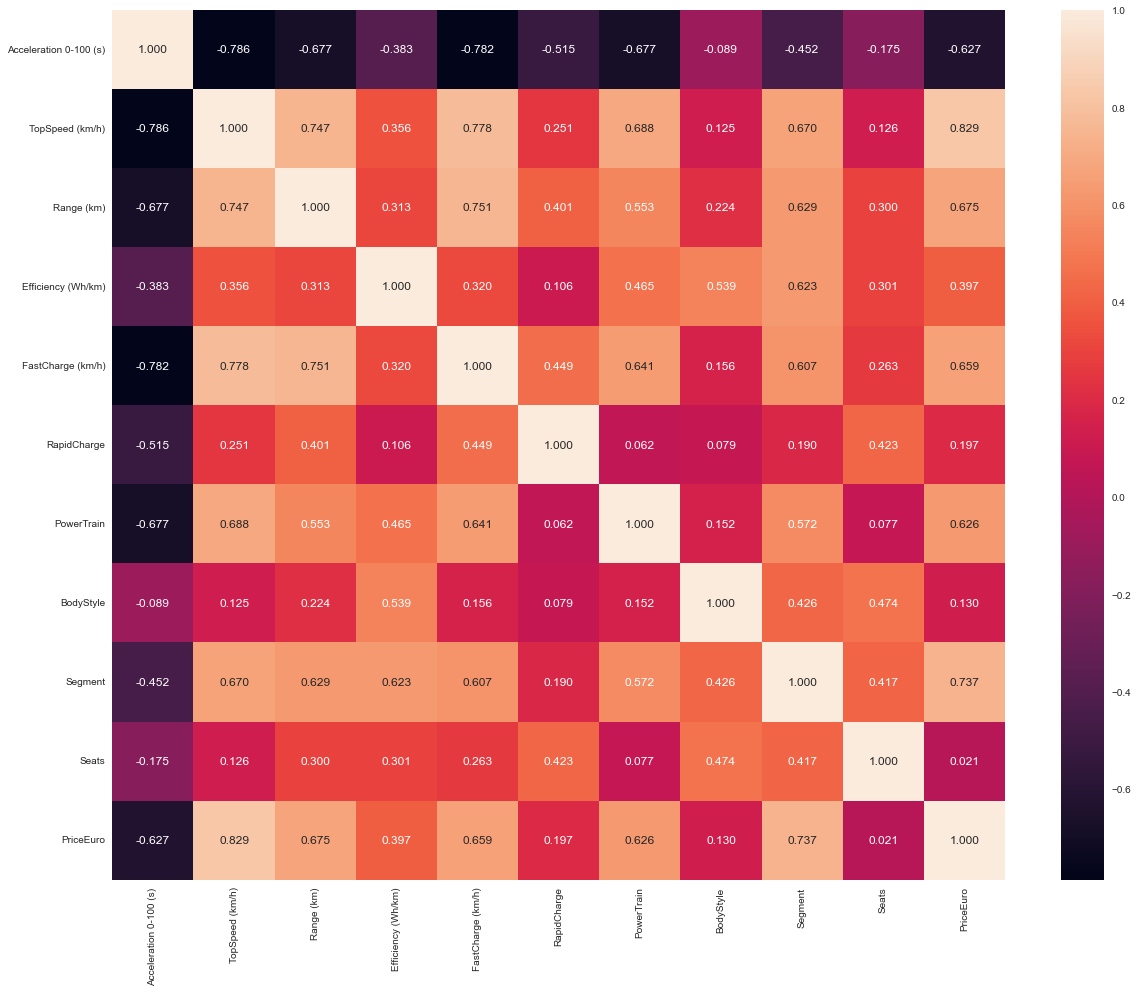

In [11]:
fig, ax = plt.subplots(figsize = (20, 16))
sns.heatmap(data.corr(), ax = ax, annot = True, fmt = ".3f")

Pairplot zobrazujúci rozmiestnenie hodnôt medzi 2 atribútmi

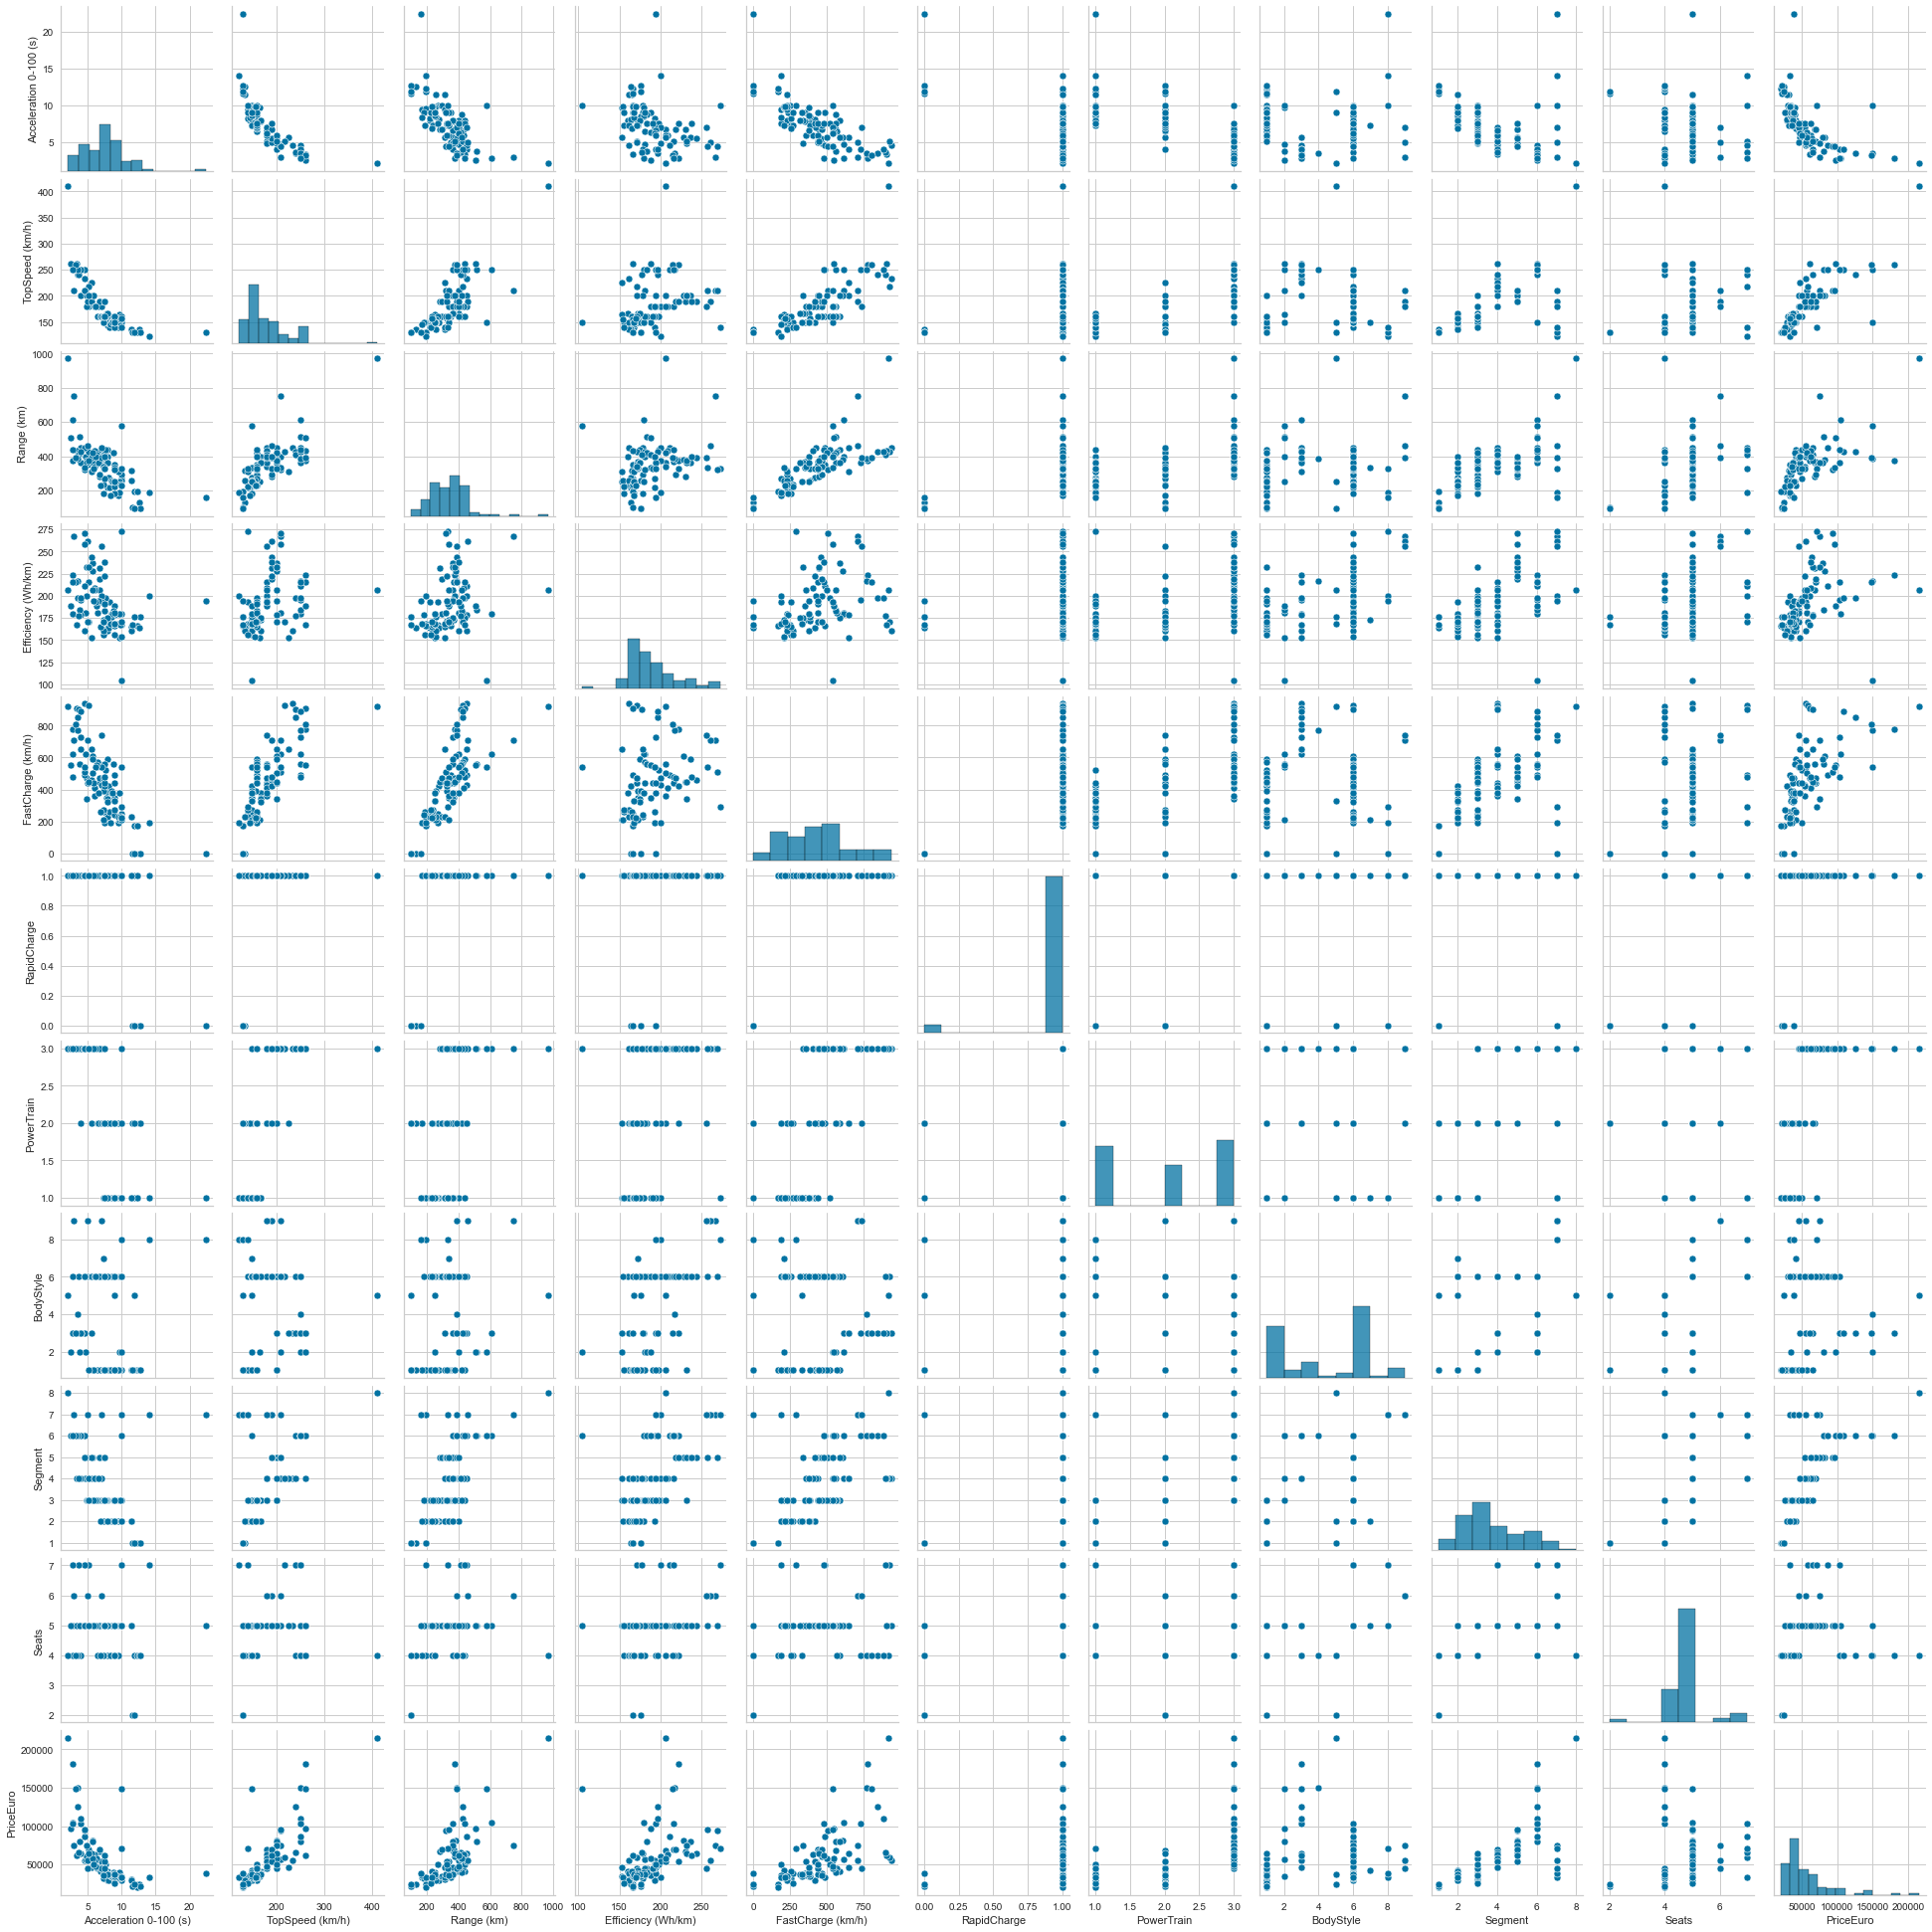

In [12]:
sns.pairplot(data)

##  Dokazovanie hypotéz

###  Hypotéza č. 1

#### Na základe akcelerácie vozidla vieme predikovať s úspešnosťou minimálne 80%, či má vozidlo poháňanú jednu nápravu (FWD / RWD) alebo má poháňané obe nápravy (AWD).

Zobrazíme si boxplot, aby sme videli rozdiely v akcelerácií podľa typu poháňanej nápravy. Vidíme, že vozidlá, ktoré majú poháňané obe nápravy (AWD) majú výrazne nižšiu akceleráciu ako vozidlá s pohonom iba jednej nápravy.

C:\Users\Martin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='PowerTrain', ylabel='Acceleration 0-100 (s)'>

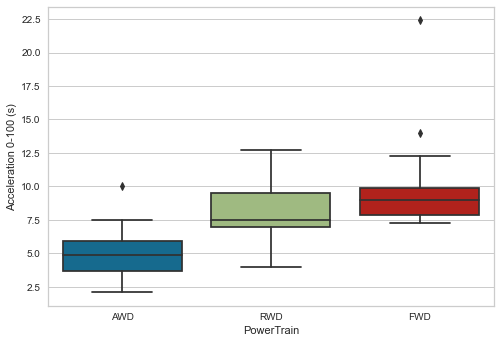

In [13]:
tempData = data.copy()
tempData['PowerTrain'].replace(to_replace=[1, 2, 3], value = ['FWD','RWD','AWD'], inplace = True)

sns.boxplot("PowerTrain", "Acceleration 0-100 (s)", data=tempData)

Vozidlá s pohonom iba jednej nápravy zoskupíme do jednej skupiny.

In [14]:
logRegData = data.copy()
logRegData['PowerTrain'].replace(to_replace=[2], value = [1], inplace = True)
x = logRegData[['Acceleration 0-100 (s)']]
y = logRegData[['PowerTrain']]

Vykreslíme si graf, ktorý nám zobrazuje rozdelenie typu pohonu podľa akcelerácie.

<AxesSubplot:xlabel='Acceleration 0-100 (s)', ylabel='PowerTrain'>

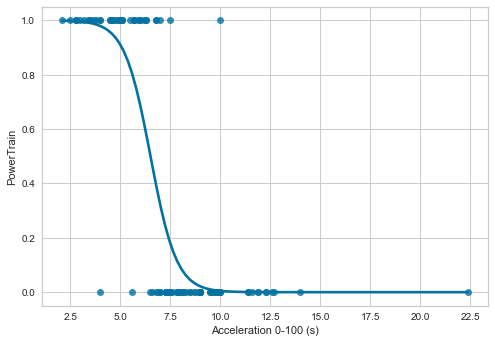

In [15]:
logRegDataPlot = data.copy()
logRegDataPlot['PowerTrain'].replace(to_replace=[1,2,3], value = [0,0,1], inplace = True)
x = logRegDataPlot[['Acceleration 0-100 (s)']]
y = logRegDataPlot[['PowerTrain']]
sns.regplot(x=x, y=y, data=logRegDataPlot, logistic=True, ci=None)

C:\Users\Martin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

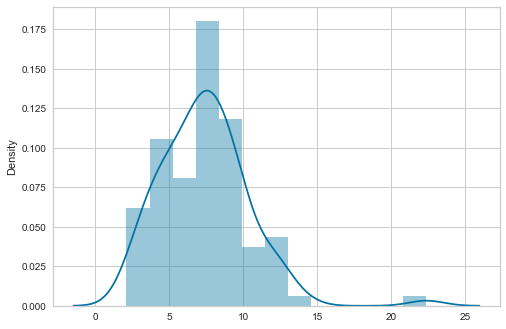

In [16]:
sns.distplot(logRegData[['Acceleration 0-100 (s)']])

Vidíme, že hodnoty nie sú z normálneho rozdelenia, tak odstránime outliere a vykreslíme si znovu graf.

C:\Users\Martin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Size of Dataset 102


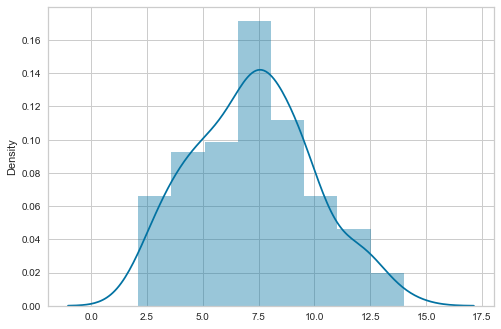

In [17]:
logRegData = logRegData.drop(identify_outliers(data['Acceleration 0-100 (s)']).index)
sns.distplot(logRegData[['Acceleration 0-100 (s)']])
print("Size of Dataset {}".format(len(logRegData)))

Po úprave má dataset 102 hodnôt. Teraz prejdeme na logistickú regresiu.

Rozdelíme si dáta na trénovaciu a testovaciu časť.

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 50)

Natrénovanie logistickej regresie

In [19]:
log = LogisticRegression()
log.fit(x_train, y_train.values.ravel())
prediction = log.predict(x_test)

print("Accuracy score on training set is {}".format(accuracy_score(log.predict(x_train),y_train)))
print("Accuracy score on test set is {}".format(accuracy_score(prediction,y_test)))

Accuracy score on training set is 0.9027777777777778
Accuracy score on test set is 0.9354838709677419


0.9444444444444444


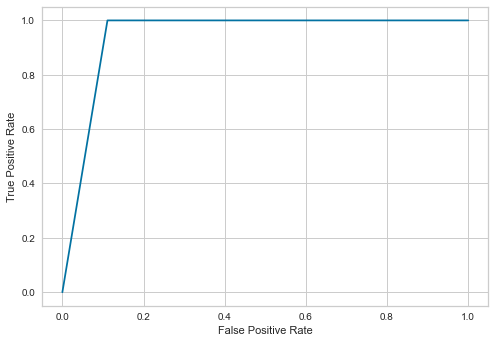

In [20]:
fpr, tpr, _ = roc_curve(y_test, prediction)

auc = roc_auc_score(y_test, prediction)
print(auc)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Vidíme, že presnosť na trénovacej aj testovacej vzorke je viac ako 90%

Zobrazenie confusion matice

In [21]:
cf_matrix = confusion_matrix(y_test, prediction)
print(cf_matrix)

[[16  2]
 [ 0 13]]


<AxesSubplot:>

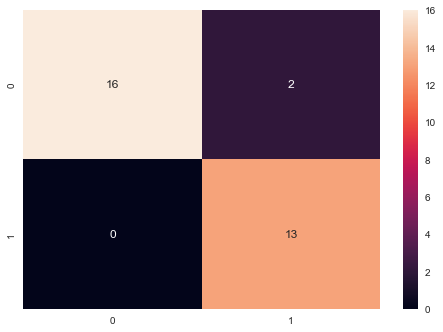

In [22]:
sns.heatmap(cf_matrix, annot=True)

Vypíšeme štatistické údaje.

In [23]:
cm = confusion_matrix(y_test,prediction)
df = pd.DataFrame(cm, index= ['0','1'], columns=['0','1'])
df = df.astype(np.int32)
df.da.export_metrics()

,0,1,micro-average
accuracy,0.935484,0.935484,0.935484
f1,0.941176,0.928571,0.935484
false_discovery_rate,0.000000,0.133333,0.064516
false_negative_rate,0.111111,0.000000,0.064516
false_positive_rate,0.000000,0.111111,0.064516
negative_predictive_value,0.866667,1.000000,0.935484
positive_predictive_value,1.000000,0.866667,0.935484
precision,1.000000,0.866667,0.935484
recall,0.888889,1.000000,0.935484
sensitivity,0.888889,1.000000,0.935484


Na základe štatistických údajov logistickej regresie sa zdá model relatívne dobrý, a preto hypotézu nezamietame. Dokázali sme, že na základe akcelerácie vozidla vieme predikovať s úspešnosťou viac ako 90% typ pohonu vozidla.

### Hypotéza č. 2

#### Chceme zistiť či cena závisí viacej na:
#####     • kategórii vozidla vzhľadom na rýchlosť (TopSpeed a Acceleration), 
 
#####     • kategórii vozidla vzhľadom na efektivitu batérie - prejdenia vzdialenosti na 1 nabitie a kapacity rýchlonabitia batérie (dojazdu) za hodinu (Range a FastCharge). 

Vozidlá si pomocou k means rozdelíme do 2 kategorii:
    - spojenim topspeed a acceleration
    - spojenim range a fastcharge

#### Acceleration - TopSpeed

In [24]:
km_data = data.copy()

Odstránenie outlierov

In [25]:
ACC_outliers = identify_outliers(km_data["Acceleration 0-100 (s)"])
km_data = km_data.drop(ACC_outliers.index)

TS_outliers = identify_outliers(km_data["TopSpeed (km/h)"])
km_data = km_data.drop(TS_outliers.index)

R_outliers = identify_outliers(km_data["Range (km)"])
km_data = km_data.drop(R_outliers.index)

FCH_outliers = identify_outliers(km_data["FastCharge (km/h)"])
km_data = km_data.drop(FCH_outliers.index)
km_data.drop(km_data.index[km_data['FastCharge (km/h)'] == 0], inplace=True)

Medzi atribútmi použijeme metódu Ordinary Least Squares regresie vzhľadom na atribút PriceEuro, aby sme získali koeficienty lineárnej regresie, ktoré opisujú vzťah medzi vybranými atribútmi.

In [26]:
x=km_data[["Acceleration 0-100 (s)", "TopSpeed (km/h)","FastCharge (km/h)", "Range (km)"]]
y=km_data['PriceEuro']
x= sm.add_constant(x)
results = sm.OLS(y,x)
model=results.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              PriceEuro   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     33.82
Date:                Fri, 01 Apr 2022   Prob (F-statistic):           2.82e-17
Time:                        22:23:44   Log-Likelihood:                -1083.3
No. Observations:                  96   AIC:                             2177.
Df Residuals:                      91   BIC:                             2189.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -7.818e+04    3.6e+04     -2.172      0.032    -1.5e+05   -6672.381
Acceleration 0-100 (s)   981.9133   1930.093      0.509      0.612   -2851.980    4815.807
TopSpeed (km/h)          607.1363    132.897      4.568      0.000     343.153     871.120
FastCharge (km/h)          0.6724     18.604      0.036      0.971     -36.281      37.626
Range (km)                52.1279     32.656      1.596      0.114     -12.740     116.996
==============================================================================
Omnibus:                       62.861   Durbin-Watson:                   2.077
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              333.125
Skew:                           2.086   Prob(JB):                     4.60e-73
Kurtosis:                      11.116   Cond. No.                     1.11e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Najviac štatisticky významný atribút je TopSpeed, pretože p-hodnota je spomedzi ostatných atribútov najnižšia a dokonca s hodnotou 0,000 je menšia ako bežná hladina alfa 0,05.

Vidíme, že existuje korelácia medzi atribútmi Acceleration - TopSpeed s hodnotou Pearsonovho korelačného koeficientu 0.893 (89.3%).

Pearson correlation: -0.893


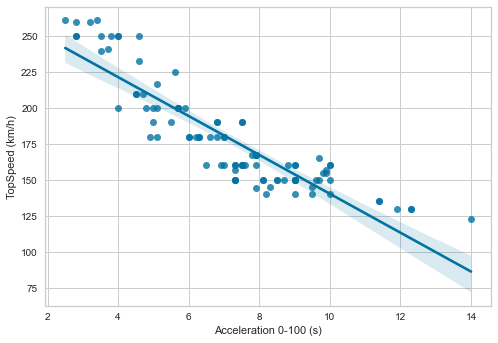

In [27]:
sns.regplot(x = "Acceleration 0-100 (s)", y = "TopSpeed (km/h)", data = km_data)
print("Pearson correlation: %.3f" % km_data["Acceleration 0-100 (s)"].corr(km_data["TopSpeed (km/h)"]))

In [28]:
df = pd.DataFrame(km_data, columns=["Acceleration 0-100 (s)", "TopSpeed (km/h)"])

Zistíme optimálny počet klastrov, čo je hodnota 3.

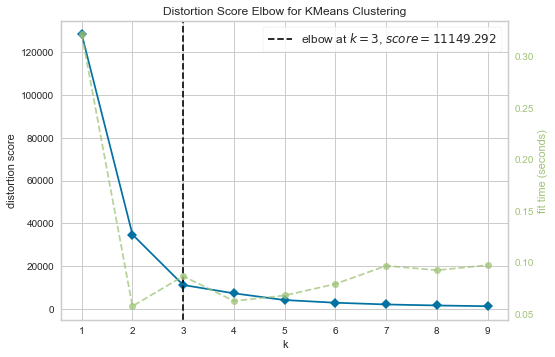

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [29]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10)).fit(df)
visualizer.show()

In [30]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=0).fit(df)

In [31]:
kmeans.labels_ = np.where(kmeans.labels_ == 1, 3, kmeans.labels_)
kmeans.labels_ = np.where(kmeans.labels_ == 2, 1, kmeans.labels_)
kmeans.labels_ = np.where(kmeans.labels_ == 3, 2, kmeans.labels_)

Vidíme koľko hodnôt je v jednotlivých klastroch.

In [32]:
Counter(kmeans.labels_)

Counter({2: 15, 0: 52, 1: 29})

Vizualizujeme rozdelenie hodnôt do klastrov.

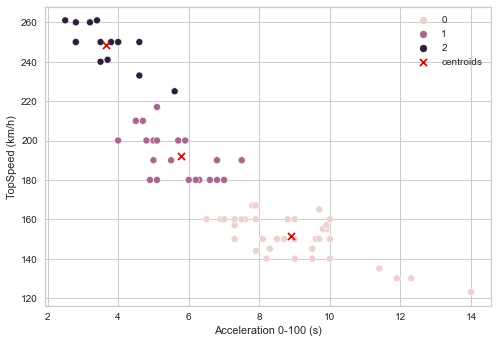

In [33]:
sns.scatterplot(data=df, x="Acceleration 0-100 (s)", y="TopSpeed (km/h)", hue=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 
            marker="x", c="r", s=50, label="centroids")
plt.legend()
plt.show()

Nový atribút si pridáme do dataframu.

In [34]:
km_data.insert(4, 'Acceleration-TopSpeed category', value = kmeans.labels_)

Rovnaký postup vykonáme aj pre skupinu atribútov Range - FastCharge.

#### Range - FastCharge

Vidíme, že existuje korelácia medzi atribútmi Range - FastCharge s hodnotou Pearsonovho korelačného koeficientu 0.751 (75.1%).

Pearson correlation: 0.711


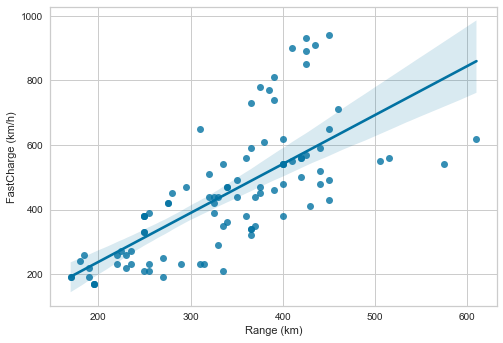

In [35]:
sns.regplot(x = "Range (km)", y = "FastCharge (km/h)", data = km_data)
print("Pearson correlation: %.3f" % km_data["Range (km)"].corr(km_data["FastCharge (km/h)"]))

In [36]:
df = pd.DataFrame(km_data, columns=["FastCharge (km/h)", "Range (km)"])

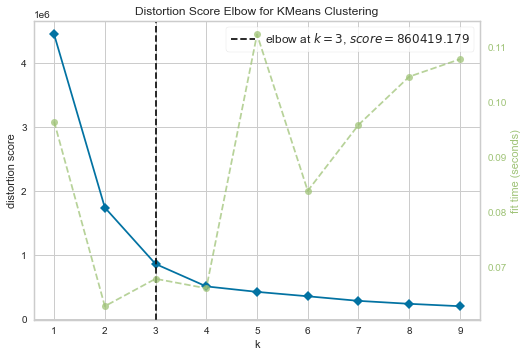

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [37]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10)).fit(df)
visualizer.show()

In [38]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=0).fit(df)

In [39]:
kmeans.labels_ = np.where(kmeans.labels_ == 0, 3, kmeans.labels_)
kmeans.labels_ = np.where(kmeans.labels_ == 1, 0, kmeans.labels_)
kmeans.labels_ = np.where(kmeans.labels_ == 3, 1, kmeans.labels_)

In [40]:
Counter(kmeans.labels_)

Counter({2: 12, 0: 38, 1: 46})

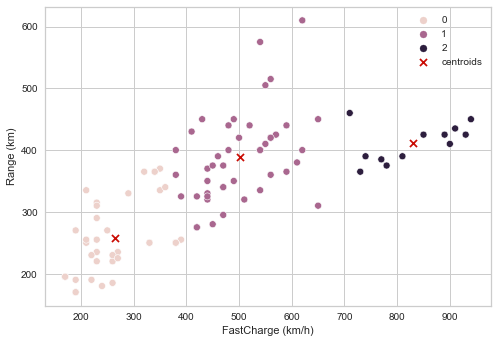

In [41]:
sns.scatterplot(data=df, x="FastCharge (km/h)", y="Range (km)", hue=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 
            marker="x", c="r", s=50, label="centroids")
plt.legend()
plt.show()

In [42]:
km_data.insert(8, 'Range-FastCharge category', value = kmeans.labels_)

 #### Logistická regresia
Medzi jednotlivými kategóriami a atribútom PriceEuro vykonáme logistickú regresiu a zistíme úspešnosť na trénovacej a testovacej sade. Zobrazíme confusion matrix a jednotlivé štatistické údaje pre obe kategórie a cenu.

Accuracy score on training set is 55.223880597014926
Accuracy score on test set is 51.724137931034484
[[15  0  0]
 [10  0  0]
 [ 4  0  0]]


<AxesSubplot:>

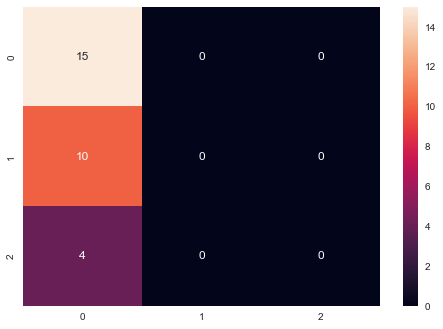

In [43]:
y1 = km_data[['Acceleration-TopSpeed category']]
x1 = km_data[['PriceEuro']]

X1_train, X1_test, y1_train, y1_test = train_test_split(x1, y1, test_size = 0.3, random_state = 365)

log = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100)
log.fit(X1_train, y1_train.values.ravel())

pred1 = log.predict(X1_train)
pred2 = log.predict(X1_test)

score=accuracy_score(y1_train,pred1)
print("Accuracy score on training set is {}".format(score*100))

score=accuracy_score(y1_test,pred2)
print("Accuracy score on test set is {}".format(score*100))

cf_matrix = confusion_matrix(y1_test, pred2)
print(cf_matrix)

sns.heatmap(cf_matrix, annot=True)

In [44]:
cm = confusion_matrix(y1_test, pred2)
df = pd.DataFrame(cm, index= ['0','1','2'], columns=['0','1','2'])
df = df.astype(np.int32)
df.da.export_metrics()

,0,1,2,micro-average
accuracy,0.517241,0.655172,0.862069,0.678161
f1,0.681818,NaN,NaN,0.517241
false_discovery_rate,0.482759,NaN,NaN,0.482759
false_negative_rate,0.000000,1.000000,1.000000,0.482759
false_positive_rate,1.000000,0.000000,0.000000,0.241379
negative_predictive_value,NaN,0.655172,0.862069,0.758621
positive_predictive_value,0.517241,NaN,NaN,0.517241
precision,0.517241,NaN,NaN,0.517241
recall,1.000000,0.000000,0.000000,0.517241
sensitivity,1.000000,0.000000,0.000000,0.517241


Accuracy score on training set is 49.25373134328358
Accuracy score on test set is 44.827586206896555
[[ 0 13  0]
 [ 0 13  0]
 [ 0  3  0]]


<AxesSubplot:>

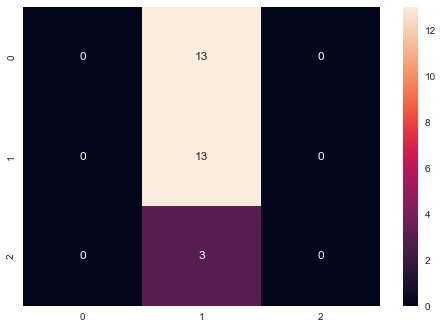

In [45]:
y1 = km_data[['Range-FastCharge category']]
x1 = km_data[['PriceEuro']]

X1_train, X1_test, y1_train, y1_test = train_test_split(x1, y1, test_size = 0.3, random_state = 365)

log = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100)
logifit = log.fit(X1_train, y1_train.values.ravel())

pred1 = log.predict(X1_train)
pred2 = log.predict(X1_test)

score=accuracy_score(y1_train,pred1)
print("Accuracy score on training set is {}".format(score*100))

score=accuracy_score(y1_test,pred2)
print("Accuracy score on test set is {}".format(score*100))

cf_matrix = confusion_matrix(y1_test, pred2)
print(cf_matrix)

sns.heatmap(cf_matrix, annot=True)

In [46]:
cm = confusion_matrix(y1_test, pred2)
df = pd.DataFrame(cm, index= ['0','1','2'], columns=['0','1','2'])
df = df.astype(np.int32)
df.da.export_metrics()

,0,1,2,micro-average
accuracy,0.551724,0.448276,0.896552,0.632184
f1,NaN,0.619048,NaN,0.448276
false_discovery_rate,NaN,0.551724,NaN,0.551724
false_negative_rate,1.000000,0.000000,1.000000,0.551724
false_positive_rate,0.000000,1.000000,0.000000,0.275862
negative_predictive_value,0.551724,NaN,0.896552,0.724138
positive_predictive_value,NaN,0.448276,NaN,0.448276
precision,NaN,0.448276,NaN,0.448276
recall,0.000000,1.000000,0.000000,0.448276
sensitivity,0.000000,1.000000,0.000000,0.448276


#### OLS regresia
Z daných hodnôt nevieme zatiaľ presne vyhodnotiť hypotézu. Preto teraz použijeme metódu Ordinary Least Squares regresie vzhľadom na atribút PriceEuro.

In [47]:
x=km_data[['Acceleration-TopSpeed category','Range-FastCharge category']]
y=km_data['PriceEuro']
x= sm.add_constant(x)
results = sm.OLS(y,x)
model=results.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              PriceEuro   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     56.41
Date:                Fri, 01 Apr 2022   Prob (F-statistic):           9.07e-17
Time:                        22:23:50   Log-Likelihood:                -1088.9
No. Observations:                  96   AIC:                             2184.
Df Residuals:                      93   BIC:                             2192.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                           3.432e+04   3132.737     10.957      0.000    2.81e+04    4.05e+04
Acceleration-TopSpeed category  2.403e+04   4211.389      5.706      0.000    1.57e+04    3.24e+04
Range-FastCharge category       8784.2499   4666.272      1.882      0.063    -482.041    1.81e+04
==============================================================================
Omnibus:                       64.286   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              382.197
Skew:                           2.087   Prob(JB):                     1.02e-83
Kurtosis:                      11.839   Cond. No.                         4.36
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Premenná Acceleration-TopSpeed category je štatisticky významná, pretože p-hodnota je 0,000 (je menšia ako bežná hladina alfa 0,05) a je nižšia ako kategórie Range-FastCharge. Na základe tohto poznatku vieme uzavrieť hypotézu so záverom, že cena vozidla (PriceEuro) viac závisí na kategórii vozidla vzhľadom na rýchlosť.

ROC krivku sme pre túto hypotézu nevedeli vykresliť, keďže sme mali viac ako 2 kategórie.

### Hypotéza č. 3

#### Maximálna rýchlosť elektrických áut najviac závisí od akcelerácie oproti ostatným atribútom, tak ako to je pri spaľovacích autách.

Zistíme od čoho najviac závisí maximálna rýchlosť.

In [48]:
x=data[['Acceleration 0-100 (s)','Range (km)', 'Efficiency (Wh/km)', 'FastCharge (km/h)', 'RapidCharge', 'PowerTrain', 'BodyStyle', 'Segment', 'Seats', 'PriceEuro']]
y=data['TopSpeed (km/h)']
x= sm.add_constant(x)
results = sm.OLS(y, x)
model=results.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        TopSpeed (km/h)   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     52.74
Date:                Fri, 01 Apr 2022   Prob (F-statistic):           9.83e-34
Time:                        22:23:50   Log-Likelihood:                -436.21
No. Observations:                 103   AIC:                             894.4
Df Residuals:                      92   BIC:                             923.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    231.1784     31.081      7.438      0.000     169.448     292.909
Acceleration 0-100 (s)    -6.8038      1.287     -5.287      0.000      -9.360      -4.248
Range (km)                 0.0388      0.024      1.606      0.112      -0.009       0.087
Efficiency (Wh/km)        -0.1697      0.092     -1.847      0.068      -0.352       0.013
FastCharge (km/h)          0.0248      0.016      1.559      0.122      -0.007       0.056
RapidCharge              -37.6846     11.918     -3.162      0.002     -61.355     -14.014
PowerTrain                -1.1606      3.453     -0.336      0.738      -8.018       5.697
BodyStyle                 -0.1473      0.936     -0.157      0.875      -2.006       1.712
Segment                    4.4558      2.400      1.856      0.067      -0.312       9.223
Seats                      0.9430      3.306      0.285      0.776      -5.623       7.509
PriceEuro                  0.0004      0.000      4.111      0.000       0.000       0.001
==============================================================================
Omnibus:                       30.705   Durbin-Watson:                   2.220
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              344.902
Skew:                          -0.341   Prob(JB):                     1.28e-75
Kurtosis:                      11.939   Cond. No.                     1.18e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.18e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Prevedieme lineárnu regresiu pre atribút "PriceEuro"

Pearson correlation: 0.855
R^2 score: 67.279


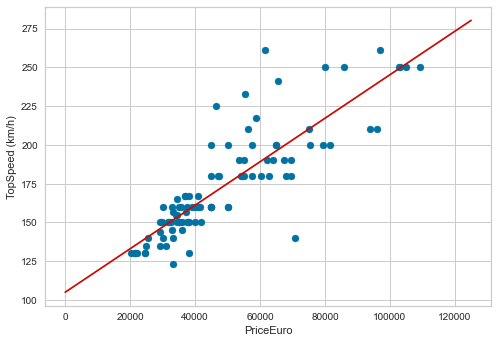

In [49]:
x = data[['PriceEuro']]
tempX = data['PriceEuro']
y = data['TopSpeed (km/h)']

ACC_outliers = identify_outliers(data["PriceEuro"])
x = x.drop(ACC_outliers.index)
tempX = tempX.drop(ACC_outliers.index)
y = y.drop(ACC_outliers.index)

TS_outliers = identify_outliers(data["TopSpeed (km/h)"])

try:
    x = x.drop(TS_outliers.index)
    tempX = tempX.drop(TS_outliers.index)
    y = y.drop(TS_outliers.index)
except:
    pass
    
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 50)

lr= LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)

print("Pearson correlation: %.3f" % tempX.corr(y))
print("R^2 score: %.3f" % ((r2_score(y_test, pred)) * 100))

mymodel = np.poly1d(np.polyfit(x.iloc[:, 0], y, 1))
myline = np.linspace(1, 125000)

plt.scatter(x, y)
plt.plot(myline, mymodel(myline), 'r')
plt.xlabel('PriceEuro')
plt.ylabel('TopSpeed (km/h)')
plt.show()

Prevedieme lineárnu regresiu pre atribút "Acceleration 0-100 (s)"

Pearson correlation: -0.893
R^2 score: 81.330


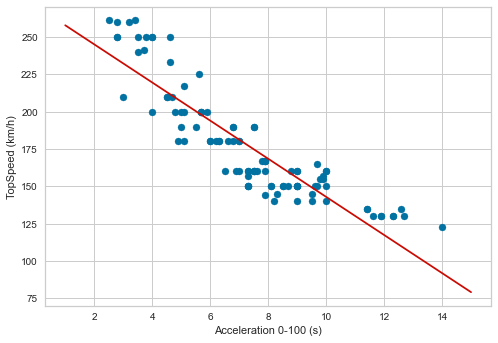

In [50]:
x=data[['Acceleration 0-100 (s)']]
tempX = data['Acceleration 0-100 (s)']
y=data['TopSpeed (km/h)']

ACC_outliers = identify_outliers(data["Acceleration 0-100 (s)"])
x = x.drop(ACC_outliers.index)
tempX = tempX.drop(ACC_outliers.index)
y = y.drop(ACC_outliers.index)

TS_outliers = identify_outliers(data["TopSpeed (km/h)"])

try:
    x = x.drop(TS_outliers.index)
    tempX = tempX.drop(TS_outliers.index)
    y = y.drop(TS_outliers.index)
except:
    pass

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 50)

lr= LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)

print("Pearson correlation: %.3f" % tempX.corr(y))
print("R^2 score: %.3f" % ((r2_score(y_test, pred)) * 100))

mymodel = np.poly1d(np.polyfit(x.iloc[:, 0], y, 1))

myline = np.linspace(1, 15)

plt.scatter(x, y)
plt.plot(myline, mymodel(myline), 'r')
plt.xlabel('Acceleration 0-100 (s)')
plt.ylabel('TopSpeed (km/h)')
plt.show()

Vypočítame Best degree function, ktorá nám povie, aký stupeň polynomiálnej regresie je najlepší.

Best degree 2 with RMSE 13.101125578163673


Text(0, 0.5, 'RMSE')

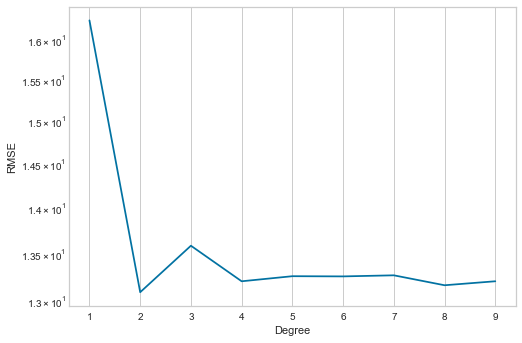

In [51]:
x=data[['Acceleration 0-100 (s)']]
y=data['TopSpeed (km/h)']

ACC_outliers = identify_outliers(data["Acceleration 0-100 (s)"])
x = x.drop(ACC_outliers.index)
y = y.drop(ACC_outliers.index)

TS_outliers = identify_outliers(data["TopSpeed (km/h)"])

try:
    x = x.drop(TS_outliers.index)
    y = y.drop(TS_outliers.index)
except:
    pass

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 50)

rmses = []
degrees = np.arange(1, 10)
min_rmse, min_deg = 1e10, 0

for deg in degrees:

    # Train features
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)
    x_poly_train = poly_features.fit_transform(x_train)

    # Linear regression
    poly_reg = LinearRegression()
    poly_reg.fit(x_poly_train, y_train)

    # Compare with test data
    x_poly_test = poly_features.fit_transform(x_test)
    poly_predict = poly_reg.predict(x_poly_test)
    poly_mse = mean_squared_error(y_test, poly_predict)
    poly_rmse = np.sqrt(poly_mse)
    rmses.append(poly_rmse)
    
    # Cross-validation of degree
    if min_rmse > poly_rmse:
        min_rmse = poly_rmse
        min_deg = deg

# Plot and present results
print('Best degree {} with RMSE {}'.format(min_deg, min_rmse))
        
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(degrees, rmses)
ax.set_yscale('log')
ax.set_xlabel('Degree')
ax.set_ylabel('RMSE')

Pokračujeme s atribútom "Acceleration 0-100 (s)" a hľadáme najlepší predikčný model.

Polynomiálna regresia so stupňom 2

R^2 score: 87.871


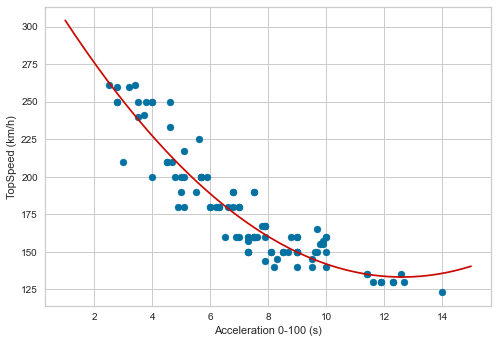

In [52]:
x=data[['Acceleration 0-100 (s)']]
y=data['TopSpeed (km/h)']

ACC_outliers = identify_outliers(data["Acceleration 0-100 (s)"])
x = x.drop(ACC_outliers.index)
y = y.drop(ACC_outliers.index)

TS_outliers = identify_outliers(data["TopSpeed (km/h)"])

try:
    x = x.drop(TS_outliers.index)
    y = y.drop(TS_outliers.index)
except:
    pass

poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(x)

X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.3, random_state = 50)

poly_reg_model = LinearRegression()
poly_reg_model.fit(X_train, y_train)

poly_reg_y_predicted = poly_reg_model.predict(X_test)
print("R^2 score: %.3f" % ((r2_score(y_test, poly_reg_y_predicted)) * 100))

mymodel = np.poly1d(np.polyfit(x.iloc[:, 0], y, 2))

myline = np.linspace(1, 15)

plt.scatter(x, y)
plt.plot(myline, mymodel(myline), 'r')
plt.xlabel('Acceleration 0-100 (s)')
plt.ylabel('TopSpeed (km/h)')
plt.show()

Polynomiálna regresia so stupňom 3.

R^2 score: 86.943


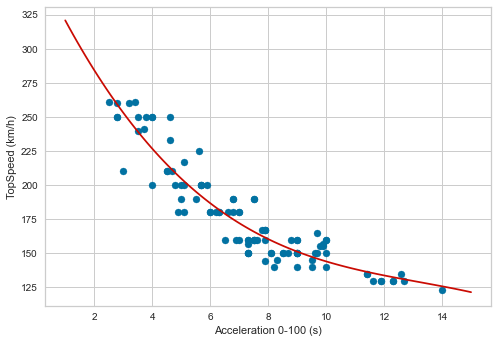

In [53]:
x=data[['Acceleration 0-100 (s)']]
y=data['TopSpeed (km/h)']

ACC_outliers = identify_outliers(data["Acceleration 0-100 (s)"])
x = x.drop(ACC_outliers.index)
y = y.drop(ACC_outliers.index)

TS_outliers = identify_outliers(data["TopSpeed (km/h)"])

try:
    x = x.drop(TS_outliers.index)
    y = y.drop(TS_outliers.index)
except:
    pass

poly = PolynomialFeatures(degree=3, include_bias=False)
poly_features = poly.fit_transform(x)

X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.3, random_state = 50)

poly_reg_model = LinearRegression()
pxy = poly_reg_model.fit(X_train, y_train)

poly_reg_y_predicted = poly_reg_model.predict(X_test)
print("R^2 score: %.3f" % ((r2_score(y_test, poly_reg_y_predicted)) * 100))

mymodel = np.poly1d(np.polyfit(x.iloc[:, 0], y, 3))

myline = np.linspace(1, 15, 100)

plt.scatter(x, y)
plt.plot(myline, mymodel(myline), 'r')
plt.xlabel('Acceleration 0-100 (s)')
plt.ylabel('TopSpeed (km/h)')
plt.show()

Aj podľa best degree function aj podľa modelov polynomiálnych regresií sme zistili, že najlepší predikčný model je polynomiálna regresia so stupňom 2. 

S vysokou pravdepodobnosťou, takmer 90% sme zistili, že rovnako ako pri spaľovacích vozidlách, tak aj pri elektrických závisí maximálna rýchlosť vozidla na akcelerácií, hypotézu nezamietame.